In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
from google.colab import files
uploaded = files.upload()


Saving Azure_Demand_Forecasting_Dataset_With_Missing_Values_2024.csv to Azure_Demand_Forecasting_Dataset_With_Missing_Values_2024.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


In [5]:
df = pd.read_csv("Azure_Demand_Forecasting_Dataset_With_Missing_Values_2024.csv")

print(df.head())


  Date_of_Usage       Region Service_Type  Demand_Units  Capacity_Allocated  \
0      1/1/2024  West Europe      Compute        1883.0                2165   
1      1/1/2024  West Europe      Storage         952.0                1094   
2      1/1/2024  South India      Compute        1748.0                2010   
3      1/1/2024  South India      Storage         937.0                1077   
4      1/1/2024      East US      Compute        2098.0                2412   

   Cost_USD  Service_Availability_Percent  Economic_Activity_Index  
0   11298.0                        99.966                   101.75  
1    4284.0                        99.914                   101.75  
2   10488.0                        99.905                   101.75  
3    4216.5                        99.964                   101.75  
4   12588.0                        99.902                   101.75  


In [6]:
df["Date_of_Usage"] = pd.to_datetime(df["Date_of_Usage"], errors="coerce")

numeric_cols = [
    "Demand_Units",
    "Capacity_Allocated",
    "Cost_USD",
    "Service_Availability_Percent",
    "Economic_Activity_Index"
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")


In [7]:
print("Missing Values Before Cleaning:")
print(df.isnull().sum())


Missing Values Before Cleaning:
Date_of_Usage                    0
Region                           0
Service_Type                     0
Demand_Units                    88
Capacity_Allocated               0
Cost_USD                        88
Service_Availability_Percent    88
Economic_Activity_Index         88
dtype: int64


In [8]:
df = df.sort_values(["Region", "Date_of_Usage"])

df["Economic_Activity_Index"] = df.groupby("Region")["Economic_Activity_Index"].ffill()


In [9]:
df["Service_Availability_Percent"] = df.groupby("Region")[
    "Service_Availability_Percent"
].transform(lambda x: x.fillna(x.mean()))


In [11]:
df["Demand_Units"] = df.groupby(
    ["Region", "Service_Type"]
)["Demand_Units"].transform(lambda x: x.interpolate(method="linear"))


In [12]:
def recalc_cost(row):
    if pd.isna(row["Cost_USD"]):
        if row["Service_Type"] == "Compute":
            return row["Demand_Units"] * 6
        else:
            return row["Demand_Units"] * 4.5
    return row["Cost_USD"]

df["Cost_USD"] = df.apply(recalc_cost, axis=1)


In [13]:
df["Capacity_Allocated"] = np.where(
    df["Capacity_Allocated"] < df["Demand_Units"],
    df["Demand_Units"] * 1.10,
    df["Capacity_Allocated"]
)


In [14]:
df["Service_Availability_Percent"] = df["Service_Availability_Percent"].clip(99, 100)


In [15]:
df["Year"] = df["Date_of_Usage"].dt.year
df["Month"] = df["Date_of_Usage"].dt.month
df["Utilization_Ratio"] = df["Demand_Units"] / df["Capacity_Allocated"]


In [16]:
print("Missing Values After Cleaning:")
print(df.isnull().sum())


Missing Values After Cleaning:
Date_of_Usage                   0
Region                          0
Service_Type                    0
Demand_Units                    0
Capacity_Allocated              0
Cost_USD                        0
Service_Availability_Percent    0
Economic_Activity_Index         0
Year                            0
Month                           0
Utilization_Ratio               0
dtype: int64


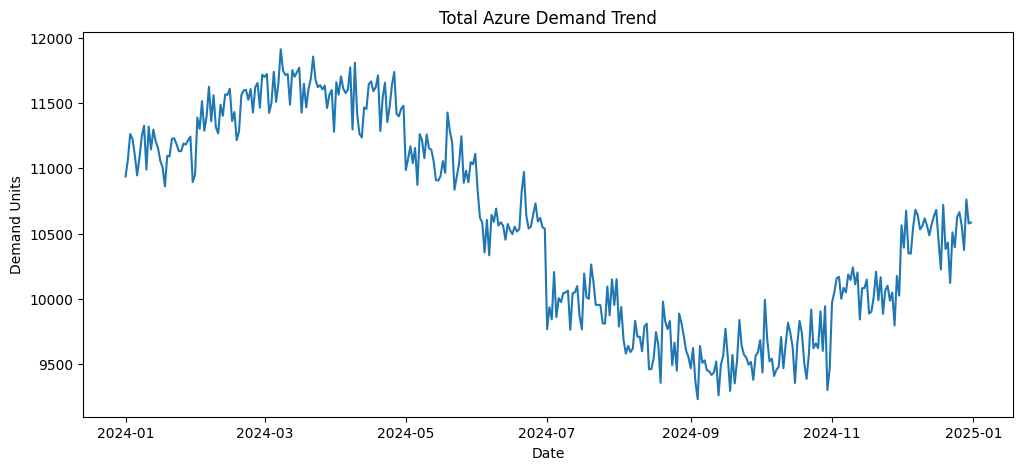

In [17]:
daily_demand = df.groupby("Date_of_Usage")["Demand_Units"].sum()

plt.figure(figsize=(12,5))
plt.plot(daily_demand)
plt.title("Total Azure Demand Trend")
plt.xlabel("Date")
plt.ylabel("Demand Units")
plt.show()


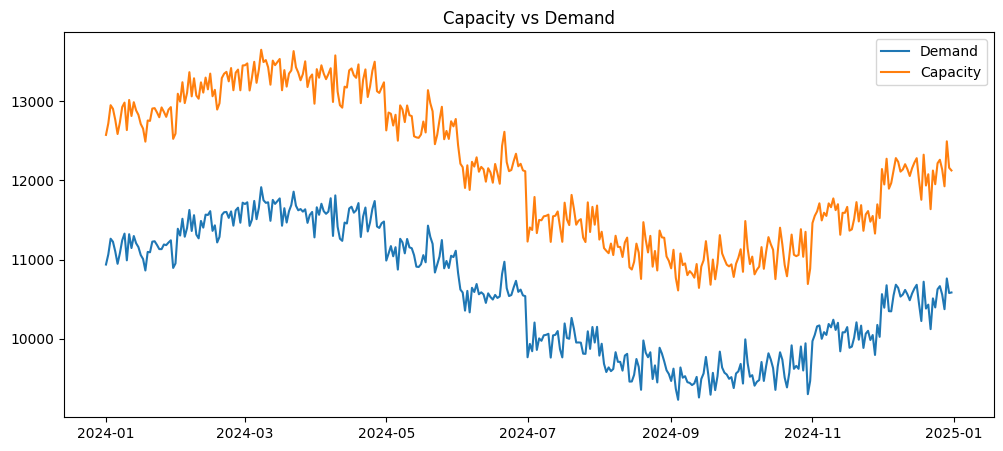

In [18]:
daily_capacity = df.groupby("Date_of_Usage")["Capacity_Allocated"].sum()
daily_demand = df.groupby("Date_of_Usage")["Demand_Units"].sum()

plt.figure(figsize=(12,5))
plt.plot(daily_demand, label="Demand")
plt.plot(daily_capacity, label="Capacity")
plt.legend()
plt.title("Capacity vs Demand")
plt.show()


In [19]:
df.to_csv("Azure_Cleaned_Dataset_2024.csv", index=False)

from google.colab import files
files.download("Azure_Cleaned_Dataset_2024.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>